In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 29.2 MB/s 
     |████████████████████████████████| 7.6 MB 88.1 MB/s 
     |████████████████████████████████| 182 kB 83.0 MB/s 


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
import transformers
from transformers import BertForSequenceClassification, BertTokenizer, BertConfig,BertModel
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from google.colab import drive
drive.mount('/content/drive')
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
train = pd.read_csv('/content/drive/MyDrive/df_train.csv', sep=",")
test = pd.read_csv('/content/drive/MyDrive/df_dev.csv', sep=",")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
config = BertConfig.from_pretrained('bert-base-uncased')

Mounted at /content/drive


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/df_train.csv', sep=",",usecols = ['Phrase','Sentiment'])
train = train.rename(columns={'Phrase': 0 , 'Sentiment' : 1})
test = pd.read_csv('/content/drive/MyDrive/df_dev.csv', sep=",",usecols = ['Phrase','Sentiment'])
test = test.rename(columns={'Phrase': 0 , 'Sentiment' : 1})


In [ ]:
class CustomBERTModel(torch.nn.Module):
    def __init__(self):
          super(CustomBERTModel, self).__init__()
          self.bert = BertModel.from_pretrained("bert-base-uncased")


    def forward(self, input_ids, attention_mask, labels=None):
          outputs = self.bert(
               input_ids, 
               attention_mask=attention_mask)
          return outputs

In [ ]:
model = CustomBERTModel()
model.cuda()

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


CustomBERTModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [ ]:
def BertModel_feature(tokenizer, model, batch_1):
  tokenized = batch_1[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

  max_len = 0
  for i in tokenized.values:
      if len(i) > max_len:
          max_len = len(i)

  padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

  attention_mask = np.where(padded != 0, 1, 0)
  attention_mask.shape

  input_ids = torch.tensor(padded).to(torch.device('cuda:0'))
  attention_mask = torch.tensor(attention_mask).to(torch.device('cuda:0'))

  with torch.no_grad():
      last_hidden_states = model(input_ids, attention_mask=attention_mask)

  features = last_hidden_states[0][:,0,:].cpu().numpy()
  return features

In [ ]:
t = 0
features = []
while t<= len(train):
  batch_1 = train[t:t+2000]
  t+= 2000
  temp = BertModel_feature(tokenizer, model, batch_1)
  if len(features)==0:
    features = temp
  else:
    features = np.concatenate((features, temp), 0)

t = 0
dev_features = []
while t<= len(test):
  batch_1 = test[t:t+2000]
  t+= 2000
  temp = BertModel_feature(tokenizer, model, batch_1)
  if len(dev_features)==0:
    dev_features = temp
  else:
    dev_features = np.concatenate((dev_features, temp), 0)

In [ ]:
from sklearn.linear_model import LogisticRegression 
labels = train[1]
dev_labels = test[1]
lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(features, labels)
y_pred = lr_clf.predict(dev_features)
print("training score:", lr_clf.score(features, labels))
print("validation score:", lr_clf.score(dev_features, dev_labels))

training score: 0.6340189670639498
validation score: 0.6233499935922081


Confusion Matrix



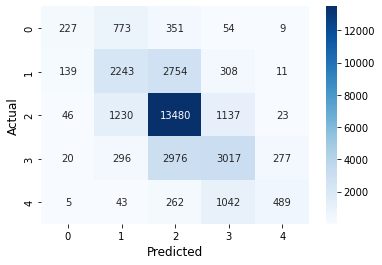


Classification Metrics

              precision    recall  f1-score   support

           0       0.52      0.16      0.25      1414
           1       0.49      0.41      0.45      5455
           2       0.68      0.85      0.75     15916
           3       0.54      0.46      0.50      6586
           4       0.60      0.27      0.37      1841

    accuracy                           0.62     31212
   macro avg       0.57      0.43      0.46     31212
weighted avg       0.61      0.62      0.60     31212



In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(dev_labels, y_pred)

print("Confusion Matrix\n")
sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual',fontsize=12)
plt.show()

lr_report = classification_report(dev_labels, y_pred)

print("\nClassification Metrics\n")
print(lr_report)

In [ ]:
id_df = pd.DataFrame(list(dev_labels), columns=['true'])
pred_df = pd.DataFrame(y_pred, columns=['pred'])
Submission_df = pd.concat([id_df, pred_df], axis=1)
Submission_df.head()

,true,pred
0,3,1
1,0,1
2,1,1
3,2,2
4,3,3


In [ ]:
Submission_df.to_csv('strongbaseline_result.csv', index=False)